In [1]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import numpy as np
import pandas as pd
from scipy import stats

import watermark

plt.style.use('./CDS_paper.mplstyle')
tab10 = plt.get_cmap("tab10").colors

%matplotlib inline
%load_ext watermark
%watermark -n -v -m -g -iv

Python implementation: CPython
Python version       : 3.9.0
IPython version      : 7.19.0

Compiler    : Clang 12.0.0 (clang-1200.0.32.27)
OS          : Darwin
Release     : 20.1.0
Machine     : x86_64
Processor   : i386
CPU cores   : 12
Architecture: 64bit

Git hash: 

numpy     : 1.19.4
scipy     : 1.5.4
pandas    : 1.1.4
matplotlib: 3.3.3
watermark : 2.1.0



Load data for all individuals in the $D$ cohort

In [2]:
D_CDS_pu_pm = pd.read_csv("results/D_CDS_count_per_month_per_individual.tsv", sep="\t", index_col=0)
D_cnt_pu_pm = pd.read_csv("results/D_tweet_count_per_month_per_individual.tsv", sep="\t", index_col=0)

Load data for all individuals in the $R$ cohort

In [3]:
R_CDS_pu_pm = pd.read_csv("results/R_CDS_count_per_month_per_individual.tsv", sep="\t", index_col=0)
R_cnt_pu_pm = pd.read_csv("results/R_tweet_count_per_month_per_individual.tsv", sep="\t", index_col=0)

Define plotting functions

In [4]:
def boxplot(ax, data, loc, color=(0, 0, 0)):    
    ax.fill_between([data.quantile(q=0.25), data.quantile(q=0.75)], loc - 0.15, loc + 0.15,
                    facecolor=(*color, 0.4), edgecolor=color, lw=3, zorder=3)
    ax.vlines(data.mean(), loc - 0.25, loc + 0.25, color=color, zorder=3)
    ax.plot([data.quantile(q=0.025), data.quantile(q=0.975)], [loc, loc],
            color=color, lw=0, marker="|", ms=12, mew=3, zorder=3)
    ax.plot([data.quantile(q=0.025), data.quantile(q=0.25)], [loc, loc], color=color, marker="", zorder=3)
    ax.plot([data.quantile(q=0.75), data.quantile(q=0.975)], [loc, loc], color=color, marker="", zorder=3)
    
    lower = data.values[data < data.quantile(q=0.025)]
    upper = data.values[data > data.quantile(q=0.975)]

    ax.scatter(lower, loc * np.ones(lower.shape), marker=".", color=color, zorder=3)
    ax.scatter(upper, loc * np.ones(upper.shape), marker=".", color=color, zorder=3)
    
    return ax


def check_significance(p):
    if p < 0.001:
        return "***"
    elif p < 0.01:
        return "**"
    elif p < 0.05:
        return "*"
    else:
        return ""


def annotate_stats(ax, D, R, loc):
    W = stats.ttest_ind(D, R, equal_var=False)
    ax.annotate(r"{}".format(check_significance(W.pvalue)), (0.99, loc + 0.075),
                xycoords="data", ha="right", va="top", fontsize=16)
    return ax

Calculate CDS prevalence

In [5]:
D_pu_pm_prev = D_CDS_pu_pm / D_cnt_pu_pm
R_pu_pm_prev = R_CDS_pu_pm / R_cnt_pu_pm

# Figure

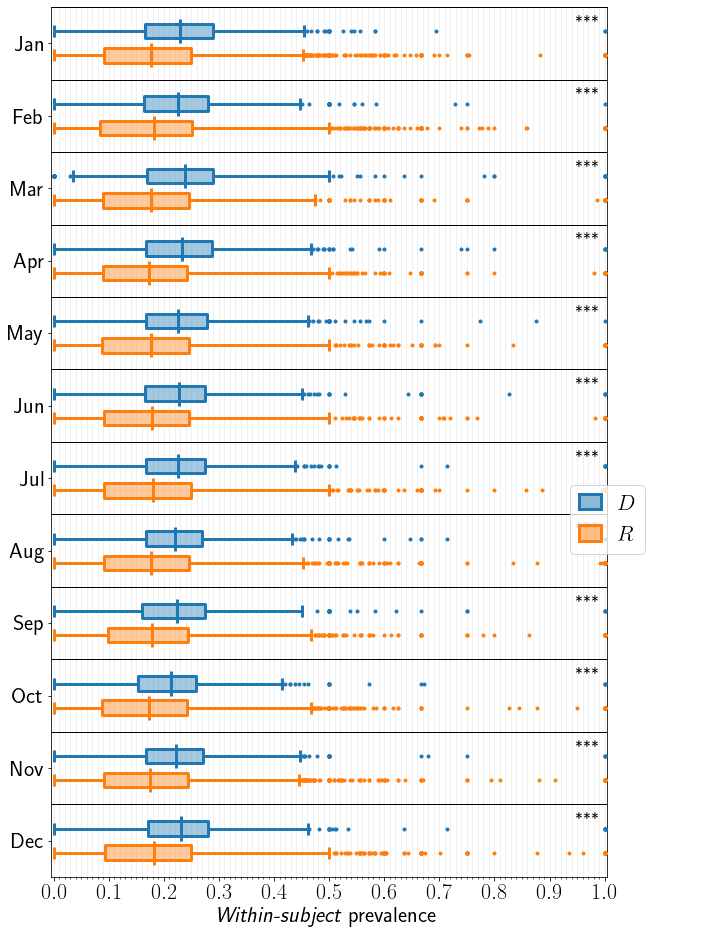

In [6]:
fig = plt.figure(figsize=(12, 16))
gs = fig.add_gridspec(8, 12)
ax2 = fig.add_subplot(gs[:, 10:])
ax2.set_axis_off()

ax = fig.add_subplot(gs[:, :10])

for num in range(12):
    ax = boxplot(ax, D_pu_pm_prev[str(num + 1)].dropna(), num * 1.5 + 0.5, color=tab10[0])
    ax = boxplot(ax, R_pu_pm_prev[str(num + 1)].dropna(), num * 1.5 + 1, color=tab10[1])
    ax = annotate_stats(ax, D_pu_pm_prev[str(num + 1)].dropna(), R_pu_pm_prev[str(num + 1)].dropna(), num * 1.5)

ax.hlines(np.arange(0, 12 * 1.5, 1.5), -0.1, 1.1, color="k", lw=1)

ax.set_xlim(-0.005, 1.005)
ax.xaxis.set_major_locator(mticker.MultipleLocator(0.1))
ax.xaxis.set_minor_locator(mticker.MultipleLocator(0.01))
ax.set_ylim(bottom=0, top=18)
ax.set_yticks(np.arange(0.75, 12 * 1.5, 1.5))
ax.set_yticklabels(pd.date_range("2019-01", "2019-12", freq="MS").strftime("%b"))
ax.yaxis.set_minor_locator(mticker.NullLocator())
ax.invert_yaxis()

ax.grid(axis="y", which="major", b=False)
ax.set_xlabel(r"\textit{Within-subject} prevalence")

t = mpatches.Patch(fc=(*tab10[0], 0.5), ec="C0", lw=3)
t2 = mpatches.Patch(fc=(*tab10[1], 0.5), ec="C1", lw=3)

fig.legend([t, t2], [r"$D$", r"$R$"], loc="upper right", bbox_to_anchor=(0.825, 0.475))

fig.savefig("figures/FigS1.pdf", dpi=600, orientation='portrait',
            facecolor='w', edgecolor='w', bbox_inches='tight')